L'objectif de ce projet est d'observer s'il existe des 'déserts sportifs', 
lieux en France où les infrastrcutures sportives manquent. 
La question sera alors d'essayer d'expliquer ces déserts sportifs, que ce soit par des raisons économiques ou politiques. 
Enfin, il s'agira de comparer la carte des déserts sportifs avec d'autres cartes connues, à l'instar des déserts médicaux.

In [1]:
#Installation et importation des modules

!pip install py7zr geopandas openpyxl tqdm s3fs --quiet
!pip install PyYAML xlrd --quiet
!pip install cartiflette --quiet
!pip install contextily --quiet

import numpy as np
import numpy.linalg as al
import matplotlib.pyplot as plt 
import pandas as pd
import geopandas as gpd
from cartiflette import carti_download
import requests
import io
import zipfile
import contextily as ctx

import tempfile

In [2]:
#Importation du jeu de données principal (localisation des équipements sportifs en France)

url = "https://data.sports.gouv.fr/api/explore/v2.1/catalog/datasets/equipements-sportifs/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
equipement = pd.read_csv(url, sep=";", low_memory=False)



#Importation d'un jeu de données csv sur des informations économiques et démographiques au niveau des communes

urlpop = "https://www.insee.fr/fr/statistiques/fichier/2521169/base_cc_comparateur_csv.zip"
response = requests.get(urlpop)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:                 #io.BytesIO évite de télécharger le fichier
    with z.open("base_cc_comparateur.csv") as csvfile:                   #sur le disque dur
        df_communes = pd.read_csv(csvfile, sep=";", low_memory=False)


#Importation d'un jeu de données politiques au niveau des communes: résultats des législatives 2024 (2nd tour)

url2="https://www.data.gouv.fr/api/1/datasets/r/5a8088fd-8168-402a-9f40-c48daab88cd1"
legislatives2=pd.read_csv(url2, sep=";", low_memory=False)

In [3]:
#Visualisation de la base de données principale
equipement.head(3)

,Numéro de l'équipement sportif,Numéro de l'installation sportive,Date de l'enquête,Nom de l'installation sportive,SIRET Installation,Adresse,Code Postal,Commune nom,Commune INSEE,Type de particularité de l'installation,...,Accessibilité aux personnes en situation de handicap sensoriel aux tribunes,Accessibilité aux personnes en situation de handicap sensoriel aux vestiaires,Longitude,Latitude,Type de particularité de l'installation (brute),Activités,QPV,QPV à 200 mètres,Catégorie,gen_2024Fin_Labellisation
0,E009I021310002,I021310002,2025-03-31,Complexe sportif,NaN,Rue de la Libération,2880,Bucy-le-Long,02131,Complexe sportif,...,False,False,3.39325,49.38809,"[""Complexe sportif""]",Tennis,NaN,NaN,NaN,NaN
1,E009I021340001,I021340001,2025-03-31,Complexe sportif,NaN,Boulevard Ornano,2500,Buire,02134,Complexe sportif,...,False,False,4.06365,49.90853,"[""Complexe sportif""]",Course sur piste,NaN,NaN,NaN,NaN
2,E009I021580001,I021580001,2025-03-31,Center Parcs,NaN,D 19 Domaine De L'Ailette,2860,Chamouille,02158,Base de plein air et/ou de loisirs,...,False,False,3.68504,49.46393,"[""Base de plein air et/ou de loisirs""]","Basket-Ball,Football / Football en salle (Futs...",NaN,NaN,proximité,NaN


In [4]:
#Visualisation de la base de données sur les informations économiques et démographiques
df_communes.head(3)

,CODGEO,P22_POP,P16_POP,SUPERF,NAIS1621,DECE1621,P22_MEN,NAISD24,DECESD24,P22_LOG,...,P22_CHOM1564,P22_ACT1564,ETTOT23,ETAZ23,ETBE23,ETFZ23,ETGU23,ETOQ23,ETTEF123,ETTEFP1023
0,01001,859.0,767.0,15.95,51.0,33.0,354.000000,8.0,4.0,379.000000,...,28.000000,431.000000,16.0,4.0,0.0,3.0,7.0,2.0,13.0,2.0
1,01002,273.0,243.0,9.15,14.0,11.0,121.000000,1.0,4.0,175.000000,...,2.000000,133.000000,4.0,1.0,0.0,0.0,2.0,1.0,3.0,0.0
2,01004,15554.0,14081.0,24.60,1325.0,808.0,7107.012476,175.0,118.0,7973.370708,...,1005.744641,7479.600207,599.0,1.0,31.0,61.0,420.0,86.0,435.0,132.0


In [5]:
#Visualisation de la base de données politique
legislatives2.head(3)

,Code département,Libellé département,Code commune,Libellé commune,Inscrits,Votants,% Votants,Abstentions,% Abstentions,Exprimés,...,Elu 17,Numéro de panneau 18,Nuance candidat 18,Nom candidat 18,Prénom candidat 18,Sexe candidat 18,Voix 18,% Voix/inscrits 18,% Voix/exprimés 18,Elu 18
0,01,Ain,01001,L'Abergement-Clémenciat,662,494,"74,62%",168,"25,38%",476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,Ain,01002,L'Abergement-de-Varey,228,187,"82,02%",41,"17,98%",166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01,Ain,01004,Ambérieu-en-Bugey,8745,5887,"67,32%",2858,"32,68%",5348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#On conserve les variables qui nous intéressent pour chaque jeu de données

#Pour le jeu de données principal
cols = ["Nom de l'installation sportive", "Code Postal", "Commune nom", "Commune INSEE", "Département Code", 
        "Département Nom", "Densite Catégorie", "Nom de l'équipement sportif", "Type d'équipement sportif", 
        "Longitude", "Latitude"]
equipement = equipement[cols]

#Pour le jeu de données sur les informations économiques et démographiques
cols = ["CODGEO", "P22_POP", "NAISD24", "DECESD24", "P22_MEN","MED21", "TP6021", "P22_CHOM1564"]
df_communes = df_communes[cols]

#Pour le jeu de données politiques
cols = ["Code commune", "Libellé commune"]
cols += [(f"% Voix/exprimés {i}") for i in range(1,5)] 
cols += [(f"Nuance candidat {i}") for i in range(1, 5)]
cols += [(f"Elu {i}") for i in range(1, 5)]

legislatives2 = legislatives2[cols]

#Transformation de la variable élu en binaire pour tous les candidats
elu_cols = [f"Elu {i}" for i in range(1, 5)] 
for col in elu_cols:
    legislatives2[col] = legislatives2[col].notna().astype(int)  #Transforme les booléens en valeur 0 ou 1

In [7]:
#Visualisation nouvelle base de données principale
equipement.head(3)

,Nom de l'installation sportive,Code Postal,Commune nom,Commune INSEE,Département Code,Département Nom,Densite Catégorie,Nom de l'équipement sportif,Type d'équipement sportif,Longitude,Latitude
0,Complexe sportif,2880,Bucy-le-Long,02131,2,Aisne,Bourgs ruraux,Courts de tennis extérieurs 2,Court de tennis,3.39325,49.38809
1,Complexe sportif,2500,Buire,02134,2,Aisne,Petites villes,Piste d'athlétisme,Piste d'athlétisme isolée,4.06365,49.90853
2,Center Parcs,2860,Chamouille,02158,2,Aisne,Rural à habitat dispersé,Plateau multisports 1,Multisports/City-stades,3.68504,49.46393


In [8]:
#Visualisation nouvelle base de données sur les informations économiques et démographiques
df_communes.head(3)

,CODGEO,P22_POP,NAISD24,DECESD24,P22_MEN,MED21,TP6021,P22_CHOM1564
0,01001,859.0,8.0,4.0,354.000000,25820,s,28.000000
1,01002,273.0,1.0,4.0,121.000000,24480,s,2.000000
2,01004,15554.0,175.0,118.0,7107.012476,21660,"17,0",1005.744641


In [9]:
#Visualisation nouvelle base de données politique
legislatives2.head(3)

,Code commune,Libellé commune,% Voix/exprimés 1,% Voix/exprimés 2,% Voix/exprimés 3,% Voix/exprimés 4,Nuance candidat 1,Nuance candidat 2,Nuance candidat 3,Nuance candidat 4,Elu 1,Elu 2,Elu 3,Elu 4
0,01001,L'Abergement-Clémenciat,"42,65%","57,35%",NaN,NaN,ENS,RN,NaN,NaN,0,1,0,0
1,01002,L'Abergement-de-Varey,"56,02%","43,98%",NaN,NaN,UG,UXD,NaN,NaN,0,1,0,0
2,01004,Ambérieu-en-Bugey,"48,73%","51,27%",NaN,NaN,UG,UXD,NaN,NaN,0,1,0,0


In [15]:
#Dictionnaire des variables utilisées dans df_commune
pd.set_option("display.max_colwidth", None)

tab_communes = {
    "Variable": [
        "CODGEO", "P22_POP", "NAISD24", "DECESD24",
        "P22_MEN", "MED21", "TP6021", "P22_CHOM1564"
    ],
    "Description": [
        "Code INSEE de la commune",
        "Population en 2022",
        "Naissances domiciliées en 2024",
        "Décès domiciliés en 2024",
        "Nombre de ménages en 2022",
        "Médiane du niveau de vie en 2021",
        "Taux de pauvreté en 2021",
        "Nombre de chômeurs de 15 à 64 ans en 2022"
    ]
}

dico_vars_communes = pd.DataFrame(tab_communes)
dico_vars_communes

,Variable,Description
0,CODGEO,Code INSEE de la commune
1,P22_POP,Population en 2022
2,NAISD24,Naissances domiciliées en 2024
3,DECESD24,Décès domiciliés en 2024
4,P22_MEN,Nombre de ménages en 2022
5,MED21,Médiane du niveau de vie en 2021
6,TP6021,Taux de pauvreté en 2021
7,P22_CHOM1564,Nombre de chômeurs de 15 à 64 ans en 2022


In [16]:
#Dictionnaire des variables utilisées dans legislatives


tab_pol = {
    "Variable": ["Code commune", "Libellé commune", "Nuance candidat", "Voix/exprimés", "Elu"],
    "Description": [
        "Code INSEE de la commune",
        "Nom de la commune",
        "Parti politique du candidat",
        "Pourcentage des suffrages exprimés pour le candidat",
        "Variable binaire égale à 1 si le candidat a été élu, 0 sinon"
    ]
}

dico_vars_pol = pd.DataFrame(tab_pol)
dico_vars_pol


,Variable,Description
0,Code commune,Code INSEE de la commune
1,Libellé commune,Nom de la commune
2,Nuance candidat,Parti politique du candidat
3,Voix/exprimés,Pourcentage des suffrages exprimés pour le candidat
4,Elu,"Variable binaire égale à 1 si le candidat a été élu, 0 sinon"


In [5]:
'''
On renomme maintenant les colonnes afin de pouvoir concatener les dataframes. 
'''

df_communes = df_communes.rename(columns={"CODGEO": "Commune INSEE"})
legislatives2 = legislatives2.rename(columns={"Code commune": "Commune INSEE"})

df_final = (
    equipement
    .merge(df_communes, on="Commune INSEE", how="left")
    .merge(legislatives2, on="Commune INSEE", how="left")
)

In [6]:
'''
On ajoute dans ce dataframe uniquement le parti politique en tête lors des élections de 2024, c'est-à-dire la nuance qui a eu
le plus de % Voix/exprimés. Pour calculer le max il faut donc remplacer les valeurs prises qui ne sont pour l'instant pas dans le bon format.
'''
cols_voix = ["% Voix/exprimés 1", "% Voix/exprimés 2", "% Voix/exprimés 3"]

for c in cols_voix:
    df_final[c] = (df_final[c].astype(str).str.replace("%", "", regex=False).str.replace(",", ".", regex=False).str.strip())

df_final["% Voix/exprimés 3"]=df_final["% Voix/exprimés 3"].str.replace("nan","0")

cols_valeurs = df_final.columns[19:22]
cols_associees = df_final.columns[22:25]

valeurs = df_final[cols_valeurs].to_numpy()
associees = df_final[cols_associees].to_numpy()
idx_max = np.argmax(valeurs, axis=1)
df_final["Score vainqueur"] = valeurs[np.arange(len(df_final)), idx_max]
df_final["Parti vainqueur"] = associees[np.arange(len(df_final)), idx_max]

In [7]:
'''
En faisant le test avec ma commune d'origine, on se rend compte que des lignes sont parfois en double, voire triple, on va donc supprimer ces doublons.
'''

test=df_final[df_final["Commune nom"] == "Eschau"]

df_final = df_final.drop_duplicates()

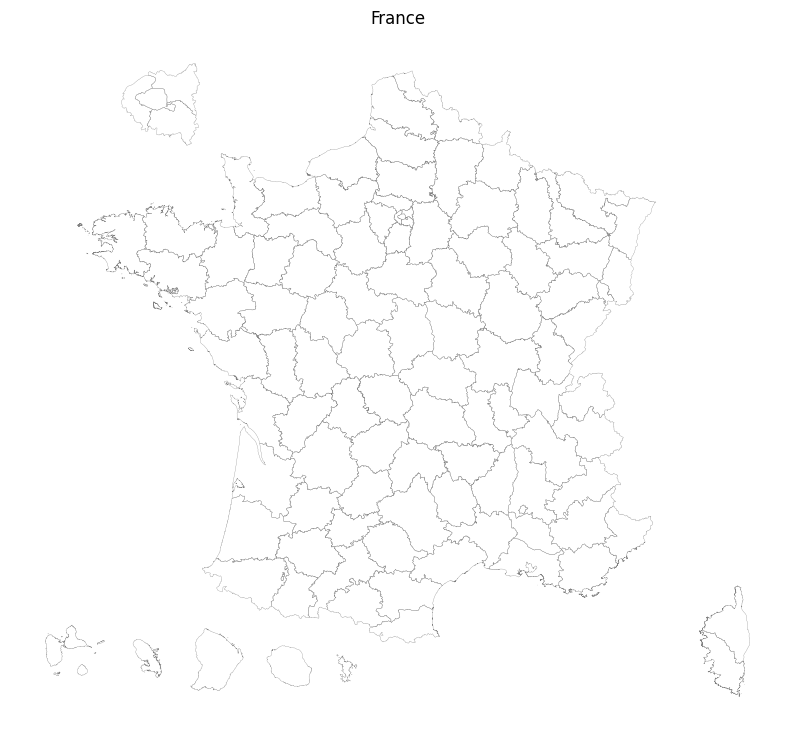

In [15]:
'''
Maintenant faisons une carte de la france avec toutes les infrastructures sportives.
1) On trace la carte de la France
'''
url_or_gdf = carti_download(
    "France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

if isinstance(url_or_gdf, gpd.GeoDataFrame):
    gdf = url_or_gdf
else:
    with tempfile.NamedTemporaryFile(suffix=".geojson", delete=False) as tmp:
        tmp.write(requests.get(url_or_gdf).content)
        local_path = tmp.name
    gdf = gpd.read_file(local_path)

gdf = gdf.to_crs("EPSG:2154")
ax = gdf.boundary.plot(figsize=(10, 12), linewidth=0.2, color="gray")
ax.set_title("France")
ax.set_axis_off()

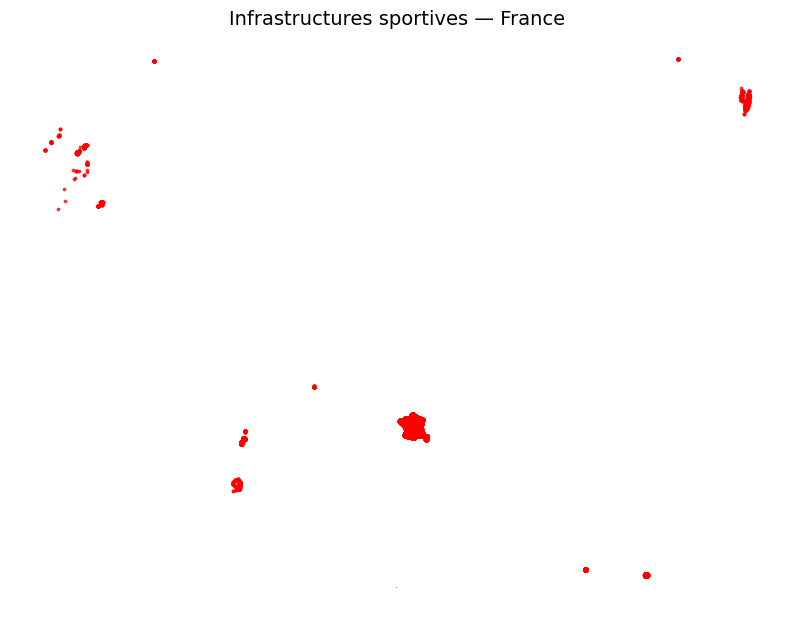

In [16]:
'''
2)On place les points des infrastructures
'''

df_final["Longitude"] = pd.to_numeric(df_final["Longitude"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
df_final["Latitude"]  = pd.to_numeric(df_final["Latitude"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
df_final = df_final.dropna(subset=["Longitude", "Latitude"]).reset_index(drop=True)

gdf_pts = gpd.GeoDataFrame(
    df_final,
    geometry=gpd.points_from_xy(df_final["Longitude"], df_final["Latitude"]),
    crs="EPSG:4326"
)

gdf_pts = gdf_pts.to_crs("EPSG:2154")

fig, ax = plt.subplots(figsize=(10, 12))
url_or_gdf.boundary.plot(ax=ax, linewidth=0.4, color="gray")
gdf_pts.plot(ax=ax, markersize=3, alpha=0.7, color="red")
ax.set_title("Infrastructures sportives — France", fontsize=14)
ax.set_axis_off()
plt.show()


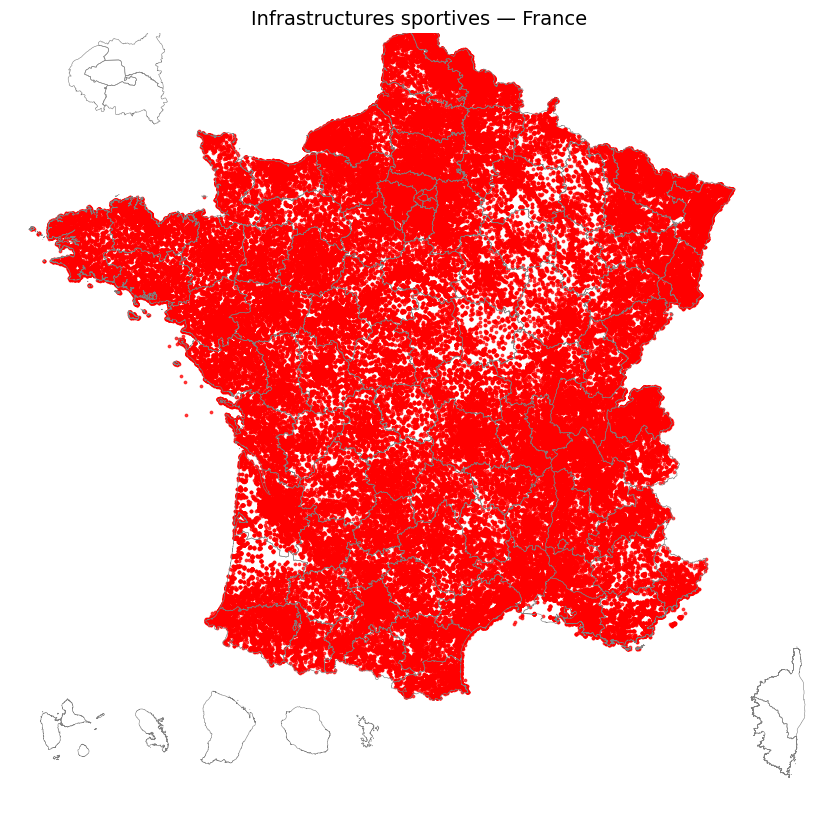

In [17]:
'''
On constate qu'on trace les pointds sur une carte monde, il faut donc enlever les données des DROM de notre df et 
garder uniquement les communes avec un code INSEE entre les départements du 01 et du 95.
'''

df_final["Département Code"] = pd.to_numeric(df_final["Département Code"], errors="coerce")

df_final_metropole = df_final[(df_final["Département Code"] >= 1) & (df_final["Département Code"] <= 95)].copy()

df_final_metropole["Longitude"] = pd.to_numeric(df_final_metropole["Longitude"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
df_final_metropole["Latitude"]  = pd.to_numeric(df_final_metropole["Latitude"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
df_final_metropole = df_final_metropole.dropna(subset=["Longitude", "Latitude"]).reset_index(drop=True)

gdf_pts = gpd.GeoDataFrame(
    df_final_metropole,
    geometry=gpd.points_from_xy(df_final_metropole["Longitude"], df_final_metropole["Latitude"]),
    crs="EPSG:4326"
)

gdf_pts = gdf_pts.to_crs("EPSG:4326")

fig, ax = plt.subplots(figsize=(20, 10))
url_or_gdf.boundary.plot(ax=ax, linewidth=0.4, color="gray")
gdf_pts.plot(ax=ax, markersize=3, alpha=0.7, color="red")
ax.set_xlim(-5.5, 10) 
ax.set_ylim(41, 51)
ax.set_title("Infrastructures sportives — France", fontsize=14)
ax.set_axis_off()